In [ ]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pmlb as dsets
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd
from numpy import array as arr

# sklearn models
sys.path.append('../scores')
import scores
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import interactions
from scipy import interpolate

In [ ]:
data_dir = '/scratch/users/vision/data/pmlb'
out_dir = '/scratch/users/vision/chandan/pmlb/classification_3' # regression_3, classification_3
# print(os.listdir(out_dir))
# this throws an err: 635_fri_c0_250_10 (reg)
random_state = 42 # for each train_test_split

In [4]:
fnames = [f for f in os.listdir(out_dir)] # if f.startswith('single')]
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames)]
# results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames)]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 133/133 [00:00<00:00, 144.85it/s]


In [5]:
# r = pd.DataFrame(pkl.load(open(oj(out_dir, 'full_results_7_full.pkl'), 'rb')))
def process_results(results):
    # get rid of list types
    for key in results.keys():
        if type(results.iloc[0][key]) == list and not type(results.iloc[0][key][0]) == np.ndarray:
            results[key] = [results.iloc[i][key][0] for i in range(results.shape[0])]
    return results
results = process_results(results)

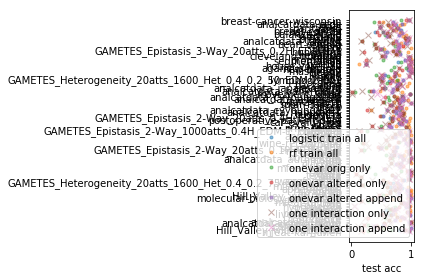

In [6]:
r = results
# plt.barh(r.dset_name, r.logit_test_score)
# plt.figure(figsize=(12, 12), dpi=200)
# plt.plot(xs, r.logit_test_score)
plt.plot(r.logit_test_score, r.dset_name, '.', label='logistic train all', alpha=0.5)
plt.plot(r.rf_test_score, r.dset_name, '.', label='rf train all', alpha=0.5)
plt.plot(r.logit_score_orig_onevar, r.dset_name, '.', label='onevar orig only', alpha=0.5)
plt.plot(r.logit_score_altered_onevar, r.dset_name, '.', label='onevar altered only', alpha=0.5)
plt.plot(r.logit_score_altered_append, r.dset_name, '.', label='onevar altered append', alpha=0.5)
plt.plot(r.logit_score_altered_interaction_onevar, r.dset_name, 'x', label='one interaction only', alpha=0.5)
plt.plot(r.logit_score_altered_interaction_append, r.dset_name, 'x', label='one interaction append', alpha=0.5)
plt.xlabel('test acc')
plt.tight_layout()
plt.legend()
plt.show()
# plt.xticks(r.dset_name, rotation='vertical')

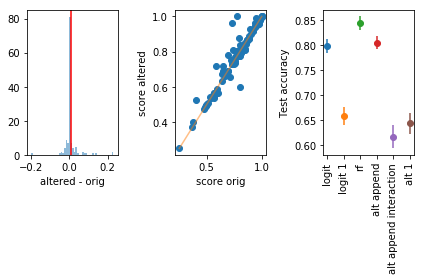

In [7]:
# plt.figure(dpi=150)

r = results
# r = r[r.rf_test_score > r.logit_test_score + 0.1]
# r = r[r.rf_test_score > r.logit_test_score + 0.2]

R, C = 1, 3
n = r.shape[0]


orig = r.logit_test_score#r.logit_test_score
orig1 = r.logit_score_orig_onevar
orig2 = r.rf_test_score
altered = r.logit_score_altered_append
altered1 = r.logit_score_altered_interaction_onevar
altered2 = r.logit_score_altered_onevar
scores = [orig, orig1, orig2, altered, altered1, altered2]
labs = ['logit', 'logit 1', 'rf', 'alt append', 'alt append interaction', 'alt 1']


plt.subplot(R, C, 1)
plt.hist(altered - orig, alpha=0.5, bins=50, label='onevar append')
plt.axvline(np.mean(altered - orig), color='red')
plt.xlabel('altered - orig')

plt.subplot(R, C, 2)
plt.plot(orig, altered, 'o')
plt.plot([np.min(altered), 1], [np.min(altered), 1], alpha=0.5)
plt.xlabel('score orig')
plt.ylabel('score altered')

plt.subplot(R, C, 3)
# plt.plot(np.zeros(n), orig, 'o', alpha=0.1)

for i, score in enumerate(scores):
    plt.errorbar(i, np.mean(score), yerr=np.std(score) / np.sqrt(n), fmt='o')

plt.xticks(range(len(labs)), labs, rotation='vertical') #['Original', 'Altered'])
plt.ylabel('Test accuracy')


plt.tight_layout()
plt.show()

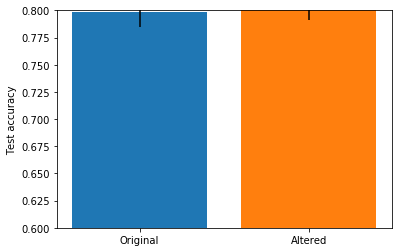

In [8]:
# plt.plot(np.zeros(n), orig, 'o', alpha=0.1)
plt.bar(0, np.mean(orig), yerr=np.std(orig) / np.sqrt(n)) #, fmt='o')

# plt.plot(np.ones(n), altered, 'o', alpha=0.1)
plt.bar(1, np.mean(altered), yerr=np.std(altered) / np.sqrt(n)) #, fmt='o')
plt.xticks([0, 1], ['Original', 'Altered'])
plt.ylabel('Test accuracy')
plt.ylim(0.6, 0.8)
plt.show()

# actual fig

In [9]:
diffs = altered - orig
idxs_sorted = np.argsort(diffs)[::-1]

altered_sorted = list(altered[idxs_sorted])
orig_sorted = list(orig[idxs_sorted])
names_sorted = list(r.dset_name[idxs_sorted])
rf_sorted = list(r.rf_test_score[idxs_sorted])

N = 10
for i in range(N):
    if i == 0:
        print('\t& ', end='')
    if i == N - 1:
        print('\\textit{' + names_sorted[i] + '}', end=' \\\\ \n')
    else:
        print('\\textit{' + names_sorted[i] + '}', end=' & ')
print('\\midrule')
for i in range(N):
    if i == 0:
        print('RF Accuracy & ', end='')
    if i == N - 1:
        print(f'{rf_sorted[i]:0.3f}', end=' \\\\ \n')
    else:
        print(f'{rf_sorted[i]:0.3f}', end=' & ')
for i in range(N):
    if i == 0:
        print('Logistic Accuracy & ', end='')
    if i == N - 1:
        print(f'{orig_sorted[i]:0.3f}', end=' \\\\ \n')
    else:
        print(f'{orig_sorted[i]:0.3f}', end=' & ')
        
for i in range(N):
    if i == 0:
        print('\\textbf{Logistic Accuracy + DAC} & ', end='')
    if i == N - 1:
        print(f'{altered_sorted[i]:0.3f}', end=' \\\\ \n')
    else:
        print(f'{altered_sorted[i]:0.3f}', end=' & ')

for i in range(N):
    if i == 0:
        print('Difference & ', end='')
    if i == N - 1:
        print(f'{altered_sorted[i] - orig_sorted[i]:0.3f}', end=' \\\\ \n')
    else:
        print(f'{altered_sorted[i] - orig_sorted[i]:0.3f}', end=' & ')    


	& \textit{monk3} & \textit{irish} & \textit{monk1} & \textit{hayes-roth} & \textit{bupa} & \textit{tokyo1} & \textit{tic-tac-toe} & \textit{buggyCrx} & \textit{agaricus-lepiota} & \textit{car} \\ 
\midrule
RF Accuracy & 0.971 & 1.000 & 0.986 & 0.825 & 0.759 & 0.900 & 0.950 & 0.884 & 1.000 & 0.977 \\ 
Logistic Accuracy & 0.734 & 0.776 & 0.583 & 0.400 & 0.690 & 0.792 & 0.650 & 0.740 & 0.946 & 0.650 \\ 
\textbf{Logistic Accuracy + DAC} & 0.964 & 1.000 & 0.719 & 0.525 & 0.782 & 0.875 & 0.721 & 0.809 & 0.989 & 0.690 \\ 
Difference & 0.230 & 0.224 & 0.137 & 0.125 & 0.092 & 0.083 & 0.071 & 0.069 & 0.042 & 0.039 \\ 


In [12]:
import matplotlib
plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


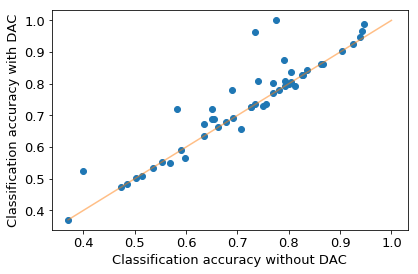

In [13]:
# plt.figure(dpi=150)

r = results
r = r[r.rf_test_score > r.logit_test_score + 0.05] # + 0.05]
# r = r[r.rf_test_score > r.logit_test_score + 0.2]
n = r.shape[0]


orig = r.logit_test_score#r.logit_test_score
orig1 = r.logit_score_orig_onevar
orig2 = r.rf_test_score
altered = r.logit_score_altered_append
altered1 = r.logit_score_altered_interaction_onevar
altered2 = r.logit_score_altered_onevar
scores = [orig, orig1, orig2, altered, altered1, altered2]
labs = ['logit', 'logit 1', 'rf', 'alt append', 'alt append interaction', 'alt 1']


plt.plot(orig, altered, 'o')
plt.plot([np.min(altered), 1], [np.min(altered), 1], alpha=0.5)
plt.xlabel('Classification accuracy without DAC')
plt.ylabel('Classification accuracy with DAC')

plt.tight_layout()
plt.savefig('pmlb.pdf')
plt.show()